
### <span style="color:blue">Omówienie zbioru danych</span>

Do zbudowania modelu predykcyjnego, a także weryfikacji jego skuteczności wykorzystano zbiór Avocado Prices (Augmented). 

Zmienna **AveragePrice** służyła jako punkt odniesienia do weryfikacji wyników predykcji. 

Do szkolenia modelu wykorzystano natomiast następujące zmienne numeryczne: 

- **Total Volume, Total Bags** – bilans zysku/strat sprzedaży awokado w przeliczeniu objętościowym oraz na torby 

- **4046, 4225, 4770** – bilans zysku/strat sprzedaży konkretnych odmian awokado (nazwa kolumny oznacza numer PLU konkretnej odmiany awokado) 

- **Date** – dzień, miesiąc i rok, w którym dokonano pomiaru powyższych wartości. Nie jest wykorzystywana w procesie uczenia bezpośrednio, ale służy do wyłuskania cech **year** i **month** 

Wykorzystano również cechę kategoryczną **type** odróżniającą odmiany awokado uprawiane w sposób naturalny (**organic**) od odmian przy uprawie których wykorzystano środki ochrony roślin (**conventional**). Naturalnie, te pierwsze cechowała wyższa cena. 

W planach było również wykorzystanie zmiennych odpowiadających porom roku, w których dokonano pomiaru (Spring, Summer, Winter, Autumn), ale ostatecznie zrezygnowano z tego pomysłu. Zastosowanie tych cech nie poprawiało istotnie rezultatów modelu. Pogarszało natomiast znacząco tempo przetwarzania danych. 

Pierwszym krokiem przy obróbce danych było wspominane wyżej wydobycie cech **month** i **year**. Cechy te, prócz wartości treningowej samej w sobie, przydane są również później przy realizacji uczenia przyrostowego. 

#### <span style="color:blue">Podgląd zbioru i wykorzystywanych w procesie uczenia cech</span>

In [326]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as sql_fun;

spark = SparkSession.builder.appName("avocado_price_prediction").getOrCreate()
df = spark.read.csv("Augmented_avocado.csv", sep = ",", header=True, inferSchema = True).drop("Unnamed: 0")

df = df.withColumn("year", sql_fun.year("Date")).withColumn("month", sql_fun.month("Date"))

training_features = ['Total Volume', '4046', '4225', '4770', 'Total Bags', 'year', 'month', 'type']
df.select(training_features).toPandas().head(10)

,Total Volume,4046,4225,4770,Total Bags,year,month,type
0,363844.119538,2086.305830,15297.247527,-513.654410,7256.068788,2017,4,organic
1,412844.368891,29015.676117,88103.386591,2253.702012,49380.191012,2015,3,conventional
2,75577.231020,25218.753758,19653.059334,-748.277093,31900.310559,2018,2,organic
3,71767.407935,4466.005801,-8540.909251,-1087.310466,16692.401787,2015,11,organic
4,77935.774076,866.915215,8097.743815,1260.251319,-6184.326714,2015,6,organic
5,357712.285175,-448.055684,97576.187841,15117.673711,27649.796899,2015,11,conventional
6,440851.604432,8230.957900,4290.935098,14053.879535,91186.041507,2016,9,conventional
7,55740.905886,-18901.979000,11176.774453,297.006553,3443.224406,2017,9,organic
8,250991.292143,14570.566944,24412.999559,-119.098441,12313.177654,2017,4,organic
9,72094.050571,3685.547568,10240.267334,1299.093415,12675.800625,2016,9,organic


#### <span style="color:blue">Rozkład cech numeryczncyh zbioru Avocado Prices</span>


Stosunkowo wysoka skośność dodatnia w przypadku przetwarzanych cech świadczy o tym, że dużo rekordów osiąga wartości poniżej średniej. Ta natomiast jest zawyżana przez obecność outlierów w zbiorze. Ponieważ rozkład cech mocno odbiega od rozkładu normalnego, wykorzystanie regresjii liniowej może budzić obawy co do rezultatów tego estymatora.

c:\Users\samur\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\samur\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\samur\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\samur\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

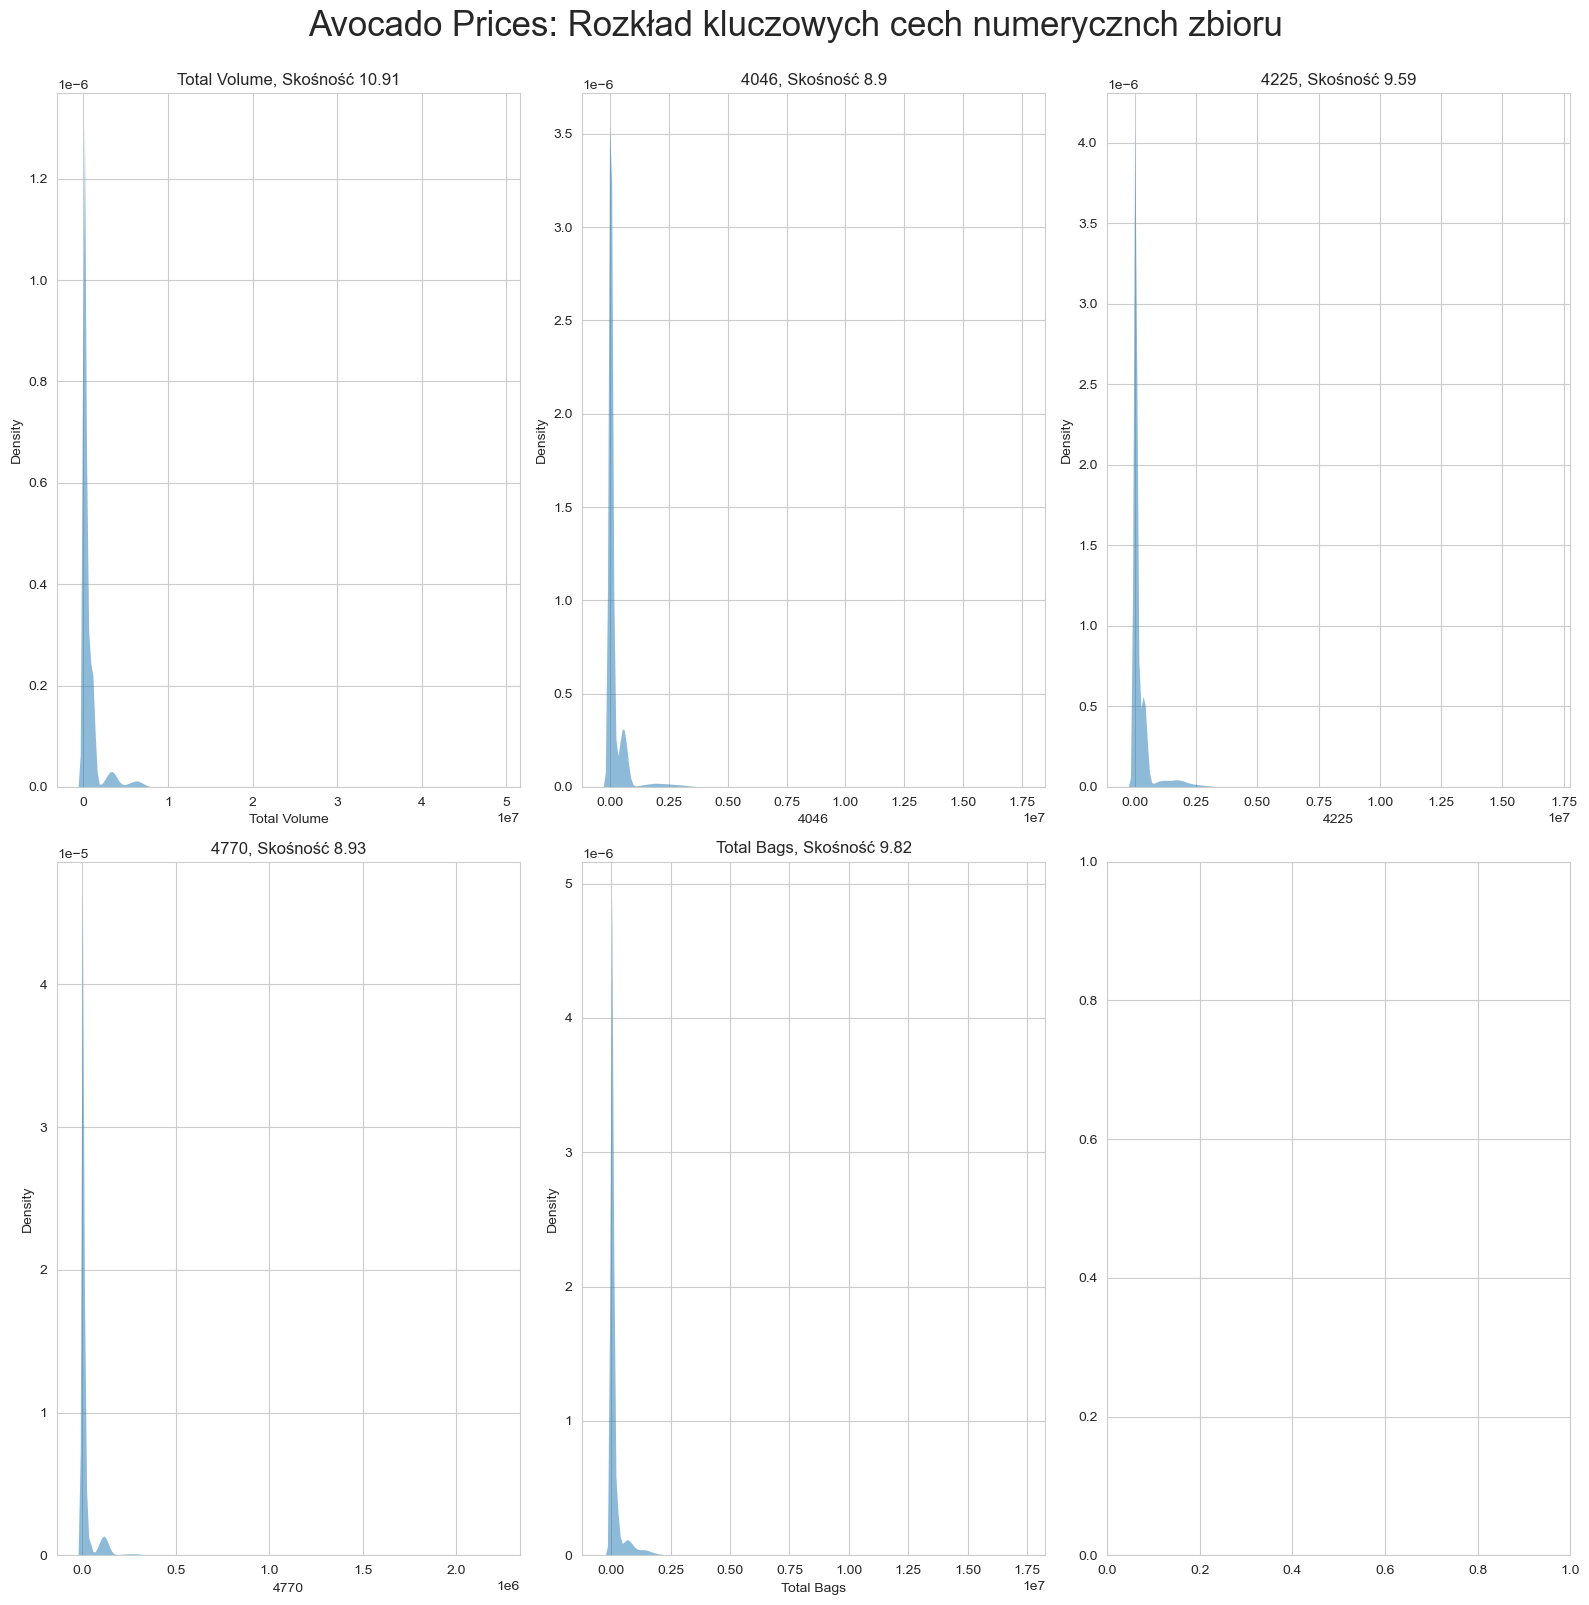

In [327]:

import matplotlib.pyplot as plt
import seaborn as sns

numerical_features = ['Total Volume', '4046', '4225', '4770', 'Total Bags']
df_pandas = df.select(numerical_features).toPandas()


def dist_custom(dataset, columns_list, rows, cols, suptitle):
    fig, axs = plt.subplots(rows, cols,figsize=(16,16))
    fig.suptitle(suptitle,y=1, size=25)
    axs = axs.flatten()
    for i, data in enumerate(columns_list):
        sns.kdeplot(dataset[data], ax=axs[i], fill=True,  alpha=.5, linewidth=0)
        axs[i].set_title(data + ', Skośność '+str(round(dataset[data].skew(axis = 0, skipna = True),2)))

dist_custom(dataset=df_pandas, columns_list=numerical_features, rows=2, cols=3, suptitle='Avocado Prices: Rozkład kluczowych cech numerycznch zbioru')
plt.tight_layout()

### <span style="color:blue">Preprocessing</span>

#### <span style="color:blue">Eliminacja outlierów</span>

Dla cechy AveragePrice dokonano eliminacji outlierów przy użyciu metody **rozstępu ćwiartkowego (IQR)**

In [328]:
initial_count = df.count()

def IQR():

    quantiles = df.approxQuantile("AveragePrice", [0.25, 0.75], 0.05)
    Q1 = quantiles[0]
    Q3 = quantiles[1]

    IQR = Q3 - Q1

    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR

    # Filter out outliers
    filtered_df = df.filter((sql_fun.col("AveragePrice") >= lower_limit) & (sql_fun.col("AveragePrice") <= upper_limit))

    return filtered_df

df = IQR()

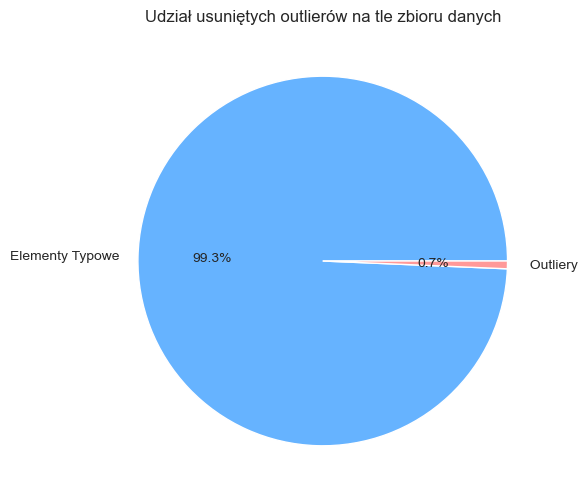

In [329]:
count_after_iqr = df.count()
counts = {"Elementy Typowe": count_after_iqr, " Outliery": initial_count - count_after_iqr}

plt.figure(figsize=(6, 6))
plt.pie(counts.values(), labels=counts.keys(), autopct='%1.1f%%', colors=["#66b3ff", "#ff9999"])
plt.title("Udział usuniętych outlierów na tle zbioru danych")
plt.show()


#### <span style="color:blue">Kodowanie cechy kategroycznej **type**</span>

Następnie należało zakodować cechę kategoryczną **type** tak aby stała się cechą numeryczną. W tym celu wykorzystano **StringIndexer** za pomocą którego odpowiednim wartościom tekstowym przypisano ID. Później kolumnę z ID cech przetworzono przy użyciu **OneHotEncodera**. Jego zadaniem było stworzenie, dla każdego wiersza, wektora cech występujących dla danego rekordu. 

In [330]:
#encode categorical features
from pyspark.ml.feature import StringIndexer, OneHotEncoder

indexer = StringIndexer(inputCol="type", outputCol="type_index")
encoder = OneHotEncoder(inputCol="type_index", outputCol="type_encoded")

#### <span style="color:blue">Rozkład ilościowy cechy type oraz idące za tym następstwa</span>

Stosunek ilości pomiarów cen awokado typu organicznego do ilości pomiarów cen awokado uprawianych z użyciem chemii gospodarczej wynosi niemalże 1:1 z lekką przewagą na korzyść cen typu organicznego. Oznacza to że, zbiór jest zrównoważony pod kątem obu wartości cechy type i żadna z wartości nie dominuje. 

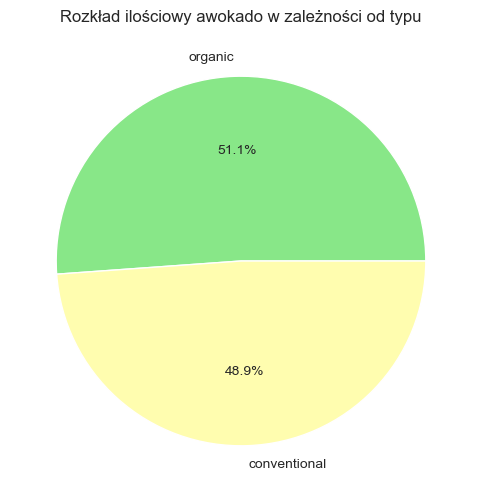

In [331]:
#Analiza rozkładu wartości zmienenej type
import matplotlib.pyplot as plt

type_counts = df.groupBy('type').count()

type_counts_pd = type_counts.toPandas()

plt.figure(figsize=(6, 6))
plt.pie(type_counts_pd["count"], labels=type_counts_pd["type"], autopct='%1.1f%%', colors=["#88e788","#fffdaf"])
plt.title("Rozkład ilościowy awokado w zależności od typu")
plt.show()

Brak znaczącej dominacji żadnego z typów jest szczególnie istotny, gdyż ceny avocado organicznego są przeważnie wyższe od cen awokado pochodzących z urpaw konwencjonalnych.

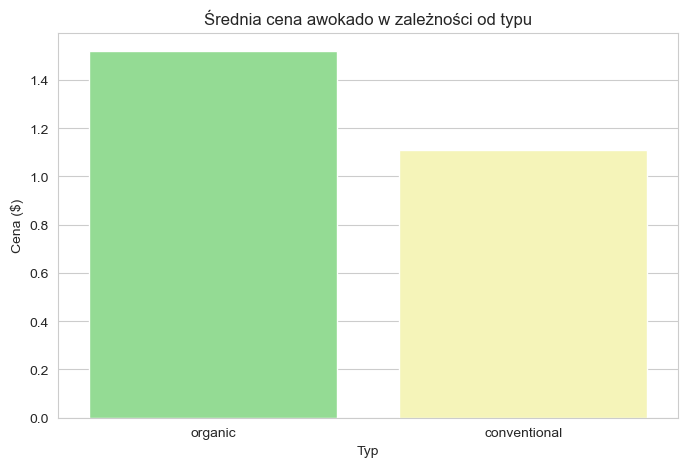

In [332]:
import matplotlib.pyplot as plt
import seaborn as sns

type_price_avg = df.select('AveragePrice', 'type').groupBy('type').avg()

type_price_avg_pd = type_price_avg.toPandas()

type_price_avg_pd.rename(columns={"avg(AveragePrice)": "AveragePrice"}, inplace=True)

# Plot Bar Chart
plt.figure(figsize=(8, 5))
sns.barplot(x="type", y="AveragePrice", data=type_price_avg_pd, palette=["#88e788","#fffdaf"])

# Customize Plot
plt.xlabel("Typ")
plt.ylabel("Cena ($)")
plt.title("Średnia cena awokado w zależności od typu")
plt.show()


#### <span style="color:blue">Tworzenie wektora cech</span>

Przygotowane cechy należało zawrzeć w jednej kolumnie przedstawiającej wektor ich wartości liczbowych. Wykorzystano do tego **VectorAssembler**. 

Przekształcanie zbioru (nie licząc operacji rozszerzenia o cechy month i year) odbywa się na końcu procesu preprocessingu wykorzystując do tego **pipeline** integrujący wszystkie niezbędne operacje. 

W ramach obróbki pod kątem wykorzystania regresji liniowej, dokonano również standaryzacji cech wykorzystując do tego **StandardScaler**. 


#### <span style="color:blue">Preprocessing pod kątem modelu regresji linowej</span>

In [333]:
from pyspark.ml.feature  import VectorAssembler, StandardScaler
from pyspark.ml import Pipeline

def linear_regression_preprocessing():

    #scale numerical features
    numerical_assembler = VectorAssembler(inputCols=numerical_features, outputCol="numerical_features")
    scaler = StandardScaler(inputCol="numerical_features", outputCol="scaled_numerical_features", withMean=True, withStd=True)

    #create features vector 
    final_assembler = VectorAssembler(inputCols=["scaled_numerical_features", "type_encoded"], outputCol="features")

    #create processing pipeline
    pipeline = Pipeline(stages=[numerical_assembler, scaler, indexer, encoder, final_assembler])

    preprocessed_df = pipeline.fit(df).transform(df)
    
    return preprocessed_df

lr_df = linear_regression_preprocessing()


#### <span style="color:blue">Preprocessing pod kątem modeli lasu losowego oraz XGBoost</span>

In [334]:
training_features = ['Total Volume', '4046', '4225', '4770', 'Total Bags', 'year', 'month', 'type_encoded']

def random_forest_and_xgb_processing():
    #create features vector 
    assemlber = VectorAssembler(inputCols=training_features, outputCol="features")

    pipeline = Pipeline(stages=[indexer, encoder, assemlber])

    preprocessed_df = pipeline.fit(df).transform(df)
    
    return preprocessed_df

rf_and_xgb_df = random_forest_and_xgb_processing()


### <span style="color:blue">Przyrostowe uczenie modelu</span>

W celu zapewnienia systemowi realistycznych warunków, zdecydowano się na przyrostowe trenowanie modelu. W tym celu zbiór danych posortowano chronologicznie, a w każdej iteracji dokładano dane z kolejnego miesiąca. 

Celem każdej iteracji była natomiast predykcja średnich cen awokado na przyszły miesiąc. Można zatem powiedzieć, że data (miesiąc i rok) danych, którymi uczymy model reprezentuje w danej iteracji teraźniejszość, z której chcemy wydobyć informacje o cenie na przyszły miesiąc. 


#### <span style="color:blue">Tworzenie estymatorów</span>

In [335]:
#Model Estimators
from pyspark.ml.regression import LinearRegression
from pyspark.ml.regression import RandomForestRegressor
from xgboost.spark import SparkXGBRegressor

lr_estimator = LinearRegression(featuresCol="features", labelCol="AveragePrice")
rf_estimator = RandomForestRegressor(featuresCol="features", labelCol="AveragePrice", numTrees=100)
xgb_estimator = SparkXGBRegressor(features_col="features", label_col="AveragePrice", prediction_col="prediction", eta=0.1, objective="reg:squarederror")



#### <span style="color:blue">Podział na zbiór treningowy i testowy</span>

In [336]:
lr_df_train, lr_df_eval = lr_df.randomSplit([0.8, 0.2], 42)
rf_and_xgb_df_train, rf_and_xgb_df_eval = rf_and_xgb_df.randomSplit([0.8, 0.2], 42)


#### <span style="color:blue">Tworzenie par miesiąc-rok</span>

In [337]:
sorted_train = lr_df.orderBy("Date")
sorted_eval = lr_df.orderBy("Date")


#Regresja Liniowa
lr_sorted_train = lr_df.orderBy("Date")
lr_sorted_eval = lr_df.orderBy("Date")
lr_year_month_pairs = sorted_train.select("year", "month").distinct().orderBy("year", "month").collect()

#Las losowy i XGBoost
rf_and_xgb_sorted_train = rf_and_xgb_df_train.orderBy("Date")
rf_and_xgb_sorted_eval = rf_and_xgb_df_train.orderBy("Date")
rf_and_xgb_year_month_pairs = sorted_train.select("year", "month").distinct().orderBy("year", "month").collect()


#### <span style="color:blue">Tworzenie ewaluatorów</span>

In [338]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator_rmse = RegressionEvaluator(labelCol="AveragePrice", predictionCol="prediction", metricName="rmse")
evaluator_r2= RegressionEvaluator(labelCol="AveragePrice", predictionCol="prediction", metricName="r2")

#### <span style="color:blue">Przetwarzanie dla regresji liniowej</span>

In [339]:
import pandas as pd

feature_cols = ["Total Volume", "4046", "4225", "4770", "Total Bags", "year", "month"]

representative_pair =  lr_year_month_pairs[0]

year, month = representative_pair["year"], representative_pair["month"]

next_year, next_month = lr_year_month_pairs[1]["year"], lr_year_month_pairs[1]["month"]

train_batch = lr_sorted_train.filter((lr_sorted_train["year"] == year) & (lr_sorted_train["month"] == month))
model = lr_estimator.fit(train_batch)

test_batch = lr_sorted_eval.filter((lr_sorted_eval["year"] == next_year) & (lr_sorted_eval["month"] == next_month))

if test_batch.count() > 0:
    predictions = model.transform(test_batch)

rmse = evaluator_rmse.evaluate(predictions)
r2 = evaluator_r2.evaluate(predictions)

# Compute Adjusted R²
n = test_batch.count()  # Number of samples
p = len(feature_cols)  # Number of predictors
adjusted_r2 = 1 - (1 - r2) * ((n - 1) / (n - p - 1)) if n > p + 1 else None

lr_results = {
        "Model": "Regresja Liniowa",
        "RMSE": round(rmse, 4),
        "R2": round(r2, 4),
        "Adjusted R2": round(adjusted_r2, 4) if adjusted_r2 else "N/A"
    }

print(lr_results)

{'Model': 'Regresja Liniowa', 'RMSE': 0.28, 'R2': 0.3461, 'Adjusted R2': 0.3459}


#### <span style="color:blue">Przetwarzanie dla lasu losowego</span>

In [340]:
import pandas as pd

feature_cols = ["Total Volume", "4046", "4225", "4770", "Total Bags", "year", "month"]

representative_pair =  lr_year_month_pairs[0]

year, month = representative_pair["year"], representative_pair["month"]

next_year, next_month = lr_year_month_pairs[1]["year"], lr_year_month_pairs[1]["month"]

train_batch = sorted_train.filter((rf_and_xgb_sorted_train["year"] == year) & (rf_and_xgb_sorted_train["month"] == month))
rf_model = rf_estimator.fit(train_batch)

test_batch = sorted_eval.filter((rf_and_xgb_sorted_eval["year"] == next_year) & (rf_and_xgb_sorted_eval["month"] == next_month))

if test_batch.count() > 0:
    rf_predictions = rf_model.transform(test_batch)

rf_rmse = evaluator_rmse.evaluate(rf_predictions)
rf_r2 = evaluator_r2.evaluate(rf_predictions)

# Compute Adjusted R²
n = test_batch.count()  # Number of samples
p = len(feature_cols)  # Number of predictors
rf_adjusted_r2 = 1 - (1 - rf_r2) * ((n - 1) / (n - p - 1)) if n > p + 1 else None

rf_results = {
        "Model": "Las Losowy",
        "RMSE": round(rf_rmse, 4),
        "R2": round(rf_r2, 4),
        "Adjusted R2": round(rf_adjusted_r2, 4) if adjusted_r2 else "N/A"
    }

print(rf_results)

{'Model': 'Las Losowy', 'RMSE': 0.2622, 'R2': 0.4265, 'Adjusted R2': 0.4263}


#### <span style="color:blue">Przetwarzanie dla XGBoost</span>

In [341]:
import pandas as pd

feature_cols = ["Total Volume", "4046", "4225", "4770", "Total Bags", "year", "month"]

representative_pair =  lr_year_month_pairs[0]

year, month = representative_pair["year"], representative_pair["month"]

next_year, next_month = lr_year_month_pairs[1]["year"], lr_year_month_pairs[1]["month"]

train_batch = sorted_train.filter((rf_and_xgb_sorted_train["year"] == year) & (rf_and_xgb_sorted_train["month"] == month))
xgb_model = xgb_estimator.fit(train_batch)

test_batch = sorted_eval.filter((rf_and_xgb_sorted_eval["year"] == next_year) & (rf_and_xgb_sorted_eval["month"] == next_month))

if test_batch.count() > 0:
    xgb_predictions = xgb_model.transform(test_batch)

xgb_rmse = evaluator_rmse.evaluate(xgb_predictions)
xgb_r2 = evaluator_r2.evaluate(xgb_predictions)

# Compute Adjusted R²
n = test_batch.count()  # Number of samples
p = len(feature_cols)  # Number of predictors
xgb_adjusted_r2 = 1 - (1 - xgb_r2) * ((n - 1) / (n - p - 1)) if n > p + 1 else None

xgb_results = {
        "Model": "XGBoost",
        "RMSE": round(xgb_rmse, 4),
        "R2": round(xgb_r2, 4),
        "Adjusted R2": round(xgb_adjusted_r2, 4) if adjusted_r2 else "N/A"
    }

print(xgb_results)

2025-02-02 04:15:34,542 INFO XGBoost-PySpark: _fit Running xgboost-2.1.3 on 1 workers with
	booster params: {'objective': 'reg:squarederror', 'device': 'cpu', 'eta': 0.1, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-02-02 04:15:43,448 INFO XGBoost-PySpark: _fit Finished xgboost training!


{'Model': 'XGBoost', 'RMSE': 0.262, 'R2': 0.4275, 'Adjusted R2': 0.4274}


### <span style="color:blue">Podsumowanie rezultatów</span>

Pod kątem trafności predykcji, regresja liniowa sposród 3 modeli wypada zdecydowanie najgorzej. Tyczy się to zarówno wartości R² (im większe tym lepiej) jak i również RMSE (im mniejsza, tym lepiej).

Model lasu losowego jak i również model XGBoost cechują się raczej porównywalnymi rezultatami w kontekście zadanego problemu, a zatem mogą być stosowane wymiennie.

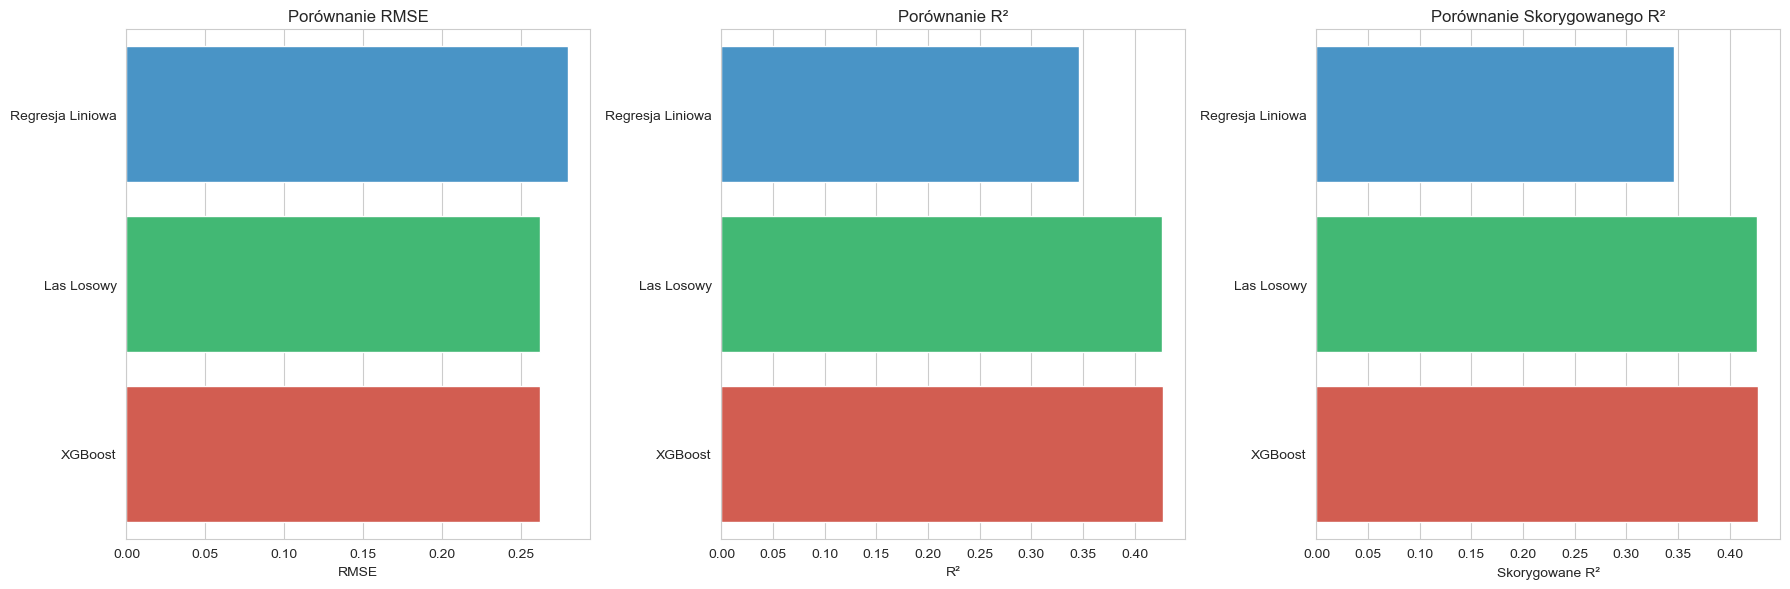

In [342]:
results_df = pd.DataFrame([lr_results, rf_results, xgb_results])

sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

colors = ["#3498db", "#2ecc71", "#e74c3c"]

#Porównanie RMSE
sns.barplot(data=results_df, y="Model", x="RMSE", ax=axes[0], palette=colors)
axes[0].set_title("Porównanie RMSE")
axes[0].set_xlabel("RMSE")
axes[0].set_ylabel("")

#Porównanie R2
sns.barplot(data=results_df, y="Model", x="R2", ax=axes[1], palette=colors)
axes[1].set_title("Porównanie R²")
axes[1].set_xlabel("R²")
axes[1].set_ylabel("")

#Porównanie skorygowanego R2
sns.barplot(data=results_df, y="Model", x="Adjusted R2", ax=axes[2], palette=colors)
axes[2].set_title("Porównanie Skorygowanego R²")
axes[2].set_xlabel("Skorygowane R²")
axes[2].set_ylabel("")

plt.tight_layout()
plt.show()

In [343]:
spark.sparkContext.stop()